Start by importing the required libraries.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
import utils_rnn
import os

Define the hyperparameters.

In [4]:
alpha = 0.001
n_input = 3
n_units = 128
max_iterations = 30000
step = 300

Import the data to pandas DataFrames.

In [3]:
data_henon = pd.read_csv("../input/henon.csv", header=None)
data_lorenz = pd.read_csv("../input/lorenz.csv", header=None)
data_rossler = pd.read_csv("../input/rossler.csv", header=None)

**Select the data that will be used for training.**

In [37]:
data = data_henon.values
n_data = data.shape[0]

Reset the Tensorflow graph to be able to re-run the code several times within the same variable scope.

In [69]:
tf.reset_default_graph()

Prepare the Tensorflow variables for weights of the LSTM cell and the Tensorflow placeholders for input/output.

In [70]:
W = tf.Variable(tf.random_normal([n_units, 1]))
b = tf.Variable(tf.random_normal([1]))
X = tf.placeholder(tf.float32, [None, n_input, 1])
y = tf.placeholder(tf.float32, [None, 1])

In [71]:
def predict(x, W, b):
    x = tf.reshape(x, [-1, n_input])
    x = tf.split(x, n_input, 1)
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_units, reuse=tf.AUTO_REUSE)
    h, c = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    return tf.matmul(h[-1], W) + b

Define Tensorflow operator for optimizing the cost.

In [72]:
y_prediction = predict(X, W, b)
cost_op = tf.reduce_sum(tf.pow(y_prediction-y, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate=alpha).minimize(cost_op)

In [73]:
def train():
    init = tf.global_variables_initializer()
    
    with tf.Session() as session:
        total_cost = 0
        total_iter_step = 1
        current_step = 0
        
        session.run(init)
        costs = []

        while(total_iter_step <= max_iterations):
            for i in range(n_data-(n_input+1)):
                current_step += 1
                cur_example = data[i:i+n_input]
                cur_example = np.reshape(np.array(cur_example), [-1, n_input, 1])
                next_value = data[i+n_input]
                next_value = np.reshape(np.array(next_value), [1, -1])

                _, cost, prediction, W_opt, b_opt = session.run([optimizer, cost_op, y_prediction, W, b],
                                                       feed_dict={X: cur_example, y: next_value})
                total_cost += cost
                total_iter_step += 1
                if total_iter_step % step == 0:
                    step_cost = total_cost / step
                    print("Iteration:", total_iter_step, "; Average Cost:", step_cost)
                    costs.append(step_cost)
                    total_cost = 0
                if total_iter_step > max_iterations:
                    break

        W_opt = np.array(W_opt)
        b_opt = np.array(b_opt)
        cost_gr.plot(list(range(1, max_iterations, step)), costs)
        #cost_gr.title("Cost for sin prediction")
        cost_gr.set_xlabel("Iterations")
        cost_gr.set_ylabel("Cost")

        # testing phase
        print("Start testing...")
        cur_X = np.array(data[:n_input])
        cur_X = np.reshape(np.array(cur_X), [-1, n_input, 1])
        tmp = data[n_input]
        tmp = np.reshape(np.array(tmp), [1, -1])
        predicted_signal = cur_X
        #for i in range(self.n_data-(n_input+1)):
        for i in range(500):
            cost, prediction = session.run([cost_op, y_prediction], feed_dict={X: cur_X, y: tmp})
            # cur_X = np.reshape(np.append(cur_X[0][1:], np.array(data[i+n_input])), [-1, n_input, 1])
            cur_X = np.reshape(np.append(cur_X[0][1:], np.array(prediction)), [-1, n_input, 1])
            predicted_signal = np.append(predicted_signal, np.array(prediction))
        print("The end.")
        
        return predicted_signal
        

In [74]:
y_pred = train()

Iteration: 300 ; Average Cost: 0.889225593037
Iteration: 600 ; Average Cost: 0.582596228292
Iteration: 900 ; Average Cost: 0.169206177074
Iteration: 1200 ; Average Cost: 0.0442148368185
Iteration: 1500 ; Average Cost: 0.0190738606451
Iteration: 1800 ; Average Cost: 0.0134214776027
Iteration: 2100 ; Average Cost: 0.0103117899823
Iteration: 2400 ; Average Cost: 0.0109176669458
Iteration: 2700 ; Average Cost: 0.00944600837646
Iteration: 3000 ; Average Cost: 0.00800146840556
Iteration: 3300 ; Average Cost: 0.0067201178857
Iteration: 3600 ; Average Cost: 0.00788898366732
Iteration: 3900 ; Average Cost: 0.00701718861433
Iteration: 4200 ; Average Cost: 0.00618627675427
Iteration: 4500 ; Average Cost: 0.00614627487288
Iteration: 4800 ; Average Cost: 0.00593673933965
Iteration: 5100 ; Average Cost: 0.00562564974353
Iteration: 5400 ; Average Cost: 0.00545309854443
Iteration: 5700 ; Average Cost: 0.00498548743864
Iteration: 6000 ; Average Cost: 0.00506506693842
Iteration: 6300 ; Average Cost: 0.0

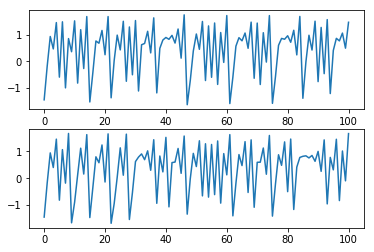

In [75]:
#fig, (cost_gr, sin_gt) = plt.subplots(2, 1)
#sin_gt.plot(data[:101], 'r', label="Given data")
#sin_gt.plot(y_pred[:101], 'b', label="Predicted data")
#sin_gt.legend(loc = "upper right")
plt.subplot(2,1,1)
plt.plot(data[:101])
plt.subplot(2,1,2)
plt.plot(y_pred[:101])
plt.show()